# Multi-label Classification

In this exercise we will classify toxic comments from online. 

In [1]:
%matplotlib inline
import re
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier


# Data loading

In [2]:
df = pd.read_csv("/dsa/data/DSA-8410/toxic/train.csv", encoding = "ISO-8859-1")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# Data exploration

### T1. Show a distribution of comments over toxic categoies.

In [3]:
#list(df_tmp.columns.values)

In [4]:
df_tmp = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_tmp.columns.values)
for i in categories:
    counts.append((i, df_tmp[i].sum()))
df_stats = pd.DataFrame(counts, columns=['comment_type', 'number_of_comments'])
df_stats

,comment_type,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5, 0, 'category')

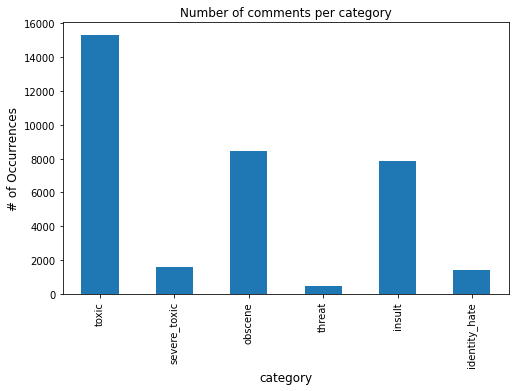

In [5]:
df_stats.plot(x='comment_type', y='number_of_comments', kind='bar', legend=False, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

### T2. Show a distribution of number of toxic categories per comment

In [6]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
x 

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

### T3. Show a distribution of comment lenght in terms of characters

In [7]:
rowsums = df['comment_text'].str.len()
x=rowsums.value_counts()
x 

24      639
31      620
34      619
33      618
32      616
       ... 
2326      1
2916      1
3501      1
4501      1
2463      1
Name: comment_text, Length: 4089, dtype: int64

### T4. Show five randomly picked comments

In [8]:
df['comment_text'].sample(n=5)#, random_state=1)

41725     Image copyright problem with Image:Video card....
48445     Anyway, the revision\n\nhttp://en.wikipedia.or...
98382     hey mind your own buisness mr.terminator.I am ...
33108     I've started a stub on MK Guth . And one for D...
156504    "::I believe you work for the correction depar...
Name: comment_text, dtype: object

# Text cleaning

Let's use the following funciton as a black box for text cleaning. 

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### T5. Apply the above function and clean the comment texts. 

In [10]:
# Saving a new copy to keep original dataset
df_new = df

df_new['clean_comment_text'] = df['comment_text'].apply(clean_text)

In [11]:
df_new.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww he matches this background colour i am s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i am really not trying to edit war it ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can not make any real suggestions on im...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


# Model development

### T6. Split data into train (80%) and test (20%)

In [12]:
X = df_new['clean_comment_text']
y = np.asarray(df_new[df_new.columns[2:-1]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

### T7. Define and train a multi-label (aka multioutput) classifier. Pick a suitable classifier as a base estimator. 

In [13]:
# Vectorize the X

vetorizer = TfidfVectorizer(max_features=1000, max_df=0.85)  # max vocabulary size is 1000
vetorizer.fit(X)

# Fit to X variables
X_train_tfidf = vetorizer.transform(X_train)
X_test_tfidf = vetorizer.transform(X_test)

# Create classifier
clf = MultiOutputClassifier(DecisionTreeClassifier())

# Train and predict
clf.fit(X_train_tfidf, y_train)
val_preds = clf.predict(X_test_tfidf)


### T8. Estimate accuracy

In [14]:
acc = np.sum(val_preds==y_test) / (y_test.shape[0]*y_test.shape[1])
print(f"Acc: {acc:.2}")

Acc: 0.97


## T9. Qualitative evaluation: Create a subset of comments where the number of predicted tags is three. Take the first ten comments and show their text, true toxic categories, and predicted categories. Write a brief comment about your observations.

In [24]:
# find samples in test having 3 predicted aspects

pos = np.where(np.sum(val_preds, 1) == 3)[0]


pos = pos[:10]

aspects = df.columns[2:-1]

for _idx in pos:
    
    print("Comment: ", X_test.iloc[_idx])
    tcol = np.where(val_preds[_idx] == 1)[0]
    print("Predicted aspect: ", [aspects[i] for i in tcol])
    tcol = np.where(y_test[_idx] == 1)[0]
    print("Actual aspect: ", [aspects[i] for i in tcol])
    print("=" * 80)
    print()

Comment:  nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigg nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigge

In [25]:
#--------------------------------- BONUS ----------------------------------------
# find samples in testing set that have 3 actual aspects

pos = np.where(np.sum(y_test, 1) == 3)[0]

# check only 10 sample
pos = pos[:10]

aspects = df.columns[2:-1]

for _idx in pos:
    
    print("Review: ", X_test.iloc[_idx])
    tcol = np.where(y_test[_idx] == 1)[0]
    print("Actual aspect: ", [aspects[i] for i in tcol])
    tcol = np.where(val_preds[_idx] == 1)[0]
    print("Predicted aspect: ", [aspects[i] for i in tcol])
    print("=" * 80)
    print()

Review:  you are gay you are the biggest drama queen i have yet come across on this wp freak show
Actual aspect:  ['toxic', 'insult', 'identity_hate']
Predicted aspect:  ['toxic', 'identity_hate']

Review:  bishonen so are you his lackey or just a sycophant he a big boy shame he has to call on his underlings to do his bidding dick laurent is dead
Actual aspect:  ['toxic', 'obscene', 'insult']
Predicted aspect:  ['toxic', 'obscene', 'insult']

Review:  first of all i wrote this and i dont want it on the page and before you call someone bloody minded you should go fuck yourself and revise your own ignorance you fucking low life scum bag
Actual aspect:  ['toxic', 'obscene', 'insult']
Predicted aspect:  ['toxic', 'obscene', 'insult']

Review:  imdb is the one who can write in not like you bitches who not can trust to fuck you soon no one would write on your fucking wikipedia even if you lick our ass
Actual aspect:  ['toxic', 'obscene', 'insult']
Predicted aspect:  ['toxic', 'severe_toxic',

Looking at the accuracy of the model (Acc: 0.97) and the above samples both from 3 predicted and 3 actual, it's clear the the model is very good at predicting the comment classification for online comments. 